In [61]:
import pandas as pd
from wassnmf.validation import generate_data
from  wassnmf.wassnmf import WassersteinNMF

/home/user920/Documents/SilkNest/pyandju/wassnmf/.venv/lib/python3.10/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [18]:
%reload_ext autoreload
%autoreload 2


In [12]:
scenario =  {
    "name": "gaussian_mixture",
    "n_samples": 20,
    "n_features": 20
}

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from geomloss import SamplesLoss  # Sinkhorn-Wasserstein loss

# Convert NumPy arrays to PyTorch tensors
def to_tensor(x, requires_grad=False, dtype=torch.float32):
    return torch.tensor(x, dtype=dtype, requires_grad=requires_grad)
# -------------------------------------------------------------------------
# Wasserstein Dictionary Learning
# -------------------------------------------------------------------------
def train_wdil(X, cost_matrix, n_components=5, lr=0.01, epochs=100):
    """
    Train Wasserstein Dictionary Learning using Sinkhorn gradient descent with a precomputed cost matrix.

    X: (n_features, n_samples) histogram data
    cost_matrix: (n_features, n_features) cost for 1D transport
    """
    # Convert data to PyTorch tensors
    X_torch = to_tensor(X, requires_grad=False)          # shape (n_features, n_samples)
    cost_matrix_torch = to_tensor(cost_matrix, requires_grad=False)  # shape (n_features, n_features)

    # -- Define a custom cost function that just returns cost_matrix for each sample in the batch --
    def cost_fn(x, y):
        """
        x, y: shape (batch_size, n_features, 1) if in measure mode.
        We must return shape (batch_size, n_features, n_features) with the cost of each pair of bins.
        """
        if len(x.shape) == 3:  # Handle GeomLoss passing (B, N, 1)
            x = x.squeeze(-1)  # Remove last dim if it's (B, N, 1)
            y = y.squeeze(-1)

        B = x.shape[0]  # Get batch size
        return cost_matrix_torch.unsqueeze(0).expand(B, -1, -1)  # Expand cost matrix for each batch

    # Initialize Dictionary (D) and Coeffs (R) randomly
    n_features, n_samples = X.shape
    D = to_tensor(np.abs(np.random.randn(n_features, n_components)), requires_grad=True)
    R = to_tensor(np.abs(np.random.randn(n_components, n_samples)), requires_grad=True)

    # Define Sinkhorn loss using our custom cost function
    sinkhorn_loss = SamplesLoss(
        loss="sinkhorn",
        cost=cost_fn,   # <--- pass the function, NOT the tensor
        blur=0.025,     
        debias=False
    )

    # Optimizer
    optimizer = optim.Adam([D, R], lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Reconstruction
        X_hat = D @ R  # shape (n_features, n_samples)

        # Sinkhorn expects (batch_size, n_features) so we do .T
        # shape = (n_samples, n_features)
        loss = sinkhorn_loss(X_torch.T, X_hat.T)

        # Optionally add a sparsity penalty on R
        loss += 0.05 * torch.sum(R * torch.log(R + 1e-9))

        # Backprop
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.4f}")

    # Return learned dictionary + coefficients in NumPy
    return D.detach().numpy(), R.detach().numpy()


In [34]:
X, K, coord, cost_matrix = generate_data(scenario=scenario)

In [64]:
wnmf = WassersteinNMF(n_components=5, verbose=True)
D_wass, Lambda_wass = wnmf.fit_transform(X, K)

  Activating project at `~/Documents/SilkNest/pyandju/wassnmf/JuWassNMF`
[ Info: Wasserstein-NMF: iteration 1
[ Info: Wasserstein-NMF: iteration 2
[ Info: Wasserstein-NMF: iteration 3
[ Info: Wasserstein-NMF: iteration 4
[ Info: Wasserstein-NMF: iteration 5
[ Info: Wasserstein-NMF: iteration 6
[ Info: Wasserstein-NMF: iteration 7
[ Info: Wasserstein-NMF: iteration 8
[ Info: Wasserstein-NMF: iteration 9
[ Info: Wasserstein-NMF: iteration 10


In [55]:
D_learned, R_learned = train_wdil(X.T, cost_matrix.T, n_components=5, lr=0.01, epochs=100)
print("D_learned shape:", D_learned.shape)
print("R_learned shape:", R_learned.shape)

Epoch 0, Loss = 0.3185
Epoch 10, Loss = -0.0863
Epoch 20, Loss = -0.3953
Epoch 30, Loss = -0.6428
Epoch 40, Loss = -0.8466
Epoch 50, Loss = -1.0165
Epoch 60, Loss = -1.1586
Epoch 70, Loss = -1.2775
Epoch 80, Loss = -1.3770
Epoch 90, Loss = -1.4601
D_learned shape: (20, 5)
R_learned shape: (5, 20)


In [45]:
import seaborn as sns

In [57]:
X_pred = D_learned @ R_learned 

In [65]:
X_wassnmf = D_wass @ Lambda_wass

<Axes: >

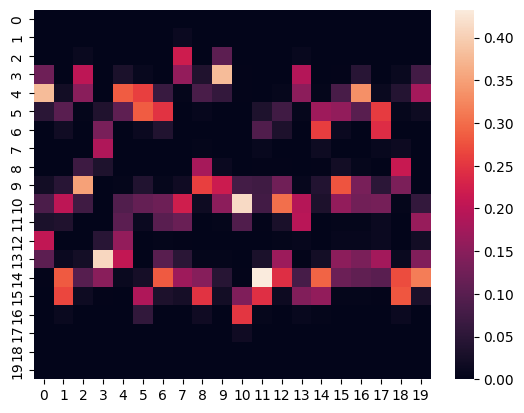

In [59]:
sns.heatmap(X)

<Axes: >

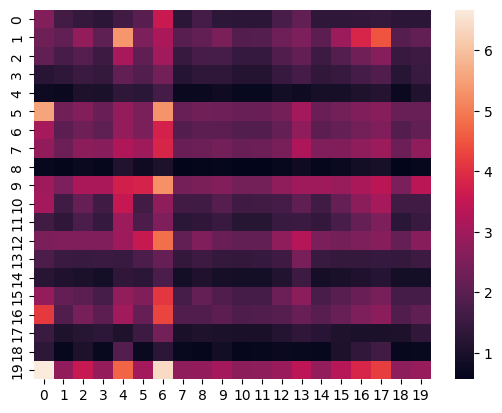

In [58]:
sns.heatmap(X_pred)

<Axes: >

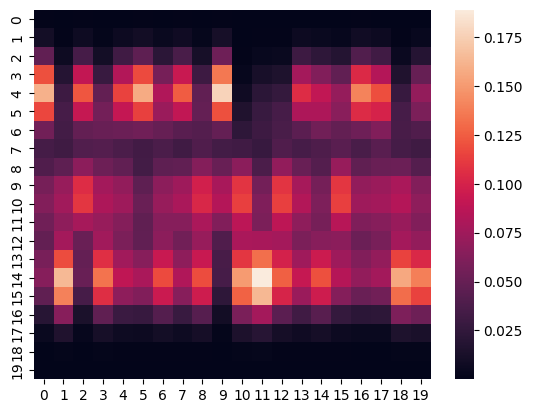

In [66]:
sns.heatmap(X_wassnmf)

<Axes: >

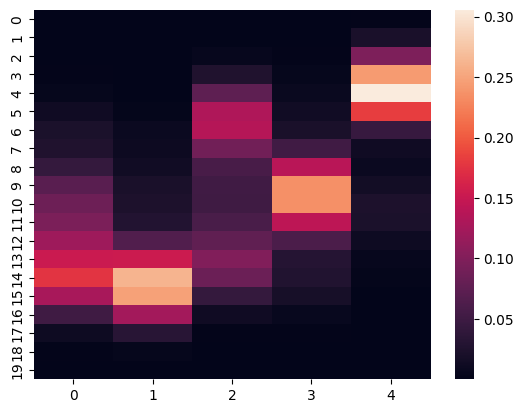

In [67]:
sns.heatmap(D_wass)

<Axes: >

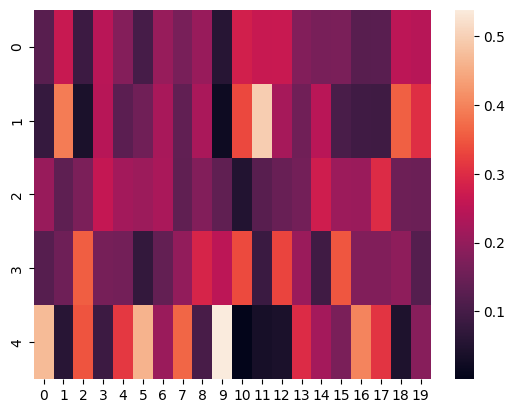

In [68]:
sns.heatmap(Lambda_wass)